In [86]:
import chainer
import numpy as np
import pyaml

from typing import Tuple
from tqdm.auto import tqdm
from dataclasses import dataclass
from pathlib import Path

from matplotlib import pyplot as plt

from fve_layer.backends.chainer.links import FVELayer

In [92]:
@dataclass
class Args(object):
    root:                Path       = Path("/home/korsch/Repos/PhD/00_DeepFVE_Layer/fve_layer/example")
    folder:              Path       = Path(".results/CUB200/sgd/2021-02-08-11.05.01.981530039")
    conv_files:          Tuple[str] = ("train_convs.npy", "val_convs.npy")
        
    batch_size:          int        = 6
    epochs:              int        = 30
    shuffle:             bool       = True
    seed:                int        = 42
        
    mask_features:       bool       = True
        
    def __str__(self):
        return pyaml.dump(self.__dict__, sort_dicts=False)

In [93]:
args = Args()

print(args)

root: /home/korsch/Repos/PhD/00_DeepFVE_Layer/fve_layer/example
folder: .results/CUB200/sgd/2021-02-08-11.05.01.981530039
conv_files:
  - train_convs.npy
  - val_convs.npy
batch_size: 6
epochs: 30
shuffle: true
seed: 42
mask_features: true



In [51]:
convs = [np.load(args.root / args.folder / file) for file in args.conv_files]

print(*[c.shape for c in convs], sep="\n")

(5994, 4, 256, 7, 7)
(5794, 4, 256, 7, 7)


In [102]:

def analyze(conv_maps):
    
    assert conv_maps.ndim == 5
    
    # n,t, c, h, w = conv_maps.shape
    # NxTxCxHxW -> NxTxHxWxC
    # conv_maps = conv_maps.transpose(0,1,3,4, 2)
    
    mean = conv_maps.mean(axis=(0, 1, 3, 4))
    std = conv_maps.std(axis=(0, 1, 3, 4))
    
    return mean, std    

def _transform_feats(feats):
    
    n, t, c, h, w = feats.shape

    # N x T x C x H x W -> N x T x H x W x C
    feats = feats.transpose(0, 1, 3, 4, 2)
    # N x T x H x W x C -> N x T*H*W x C
    feats = feats.reshape(n, t*h*w, c)

    return feats

def online_estimate(args: Args, conv_maps):
    assert conv_maps.ndim == 5
    
    rnd = np.random.RandomState(args.seed)
    
    n,t, c, h, w = conv_maps.shape
    layer = FVELayer(in_size=c, n_components=1)
    
    n_batches = np.ceil(n / args.batch_size)
    
    epochs_bar = tqdm(total=args.epochs, desc="Total Progress")
    samples_bar = tqdm(total=int(n_batches), desc="Epoch Progress")
    
    mus, sigs = [], []
    
    for epoch in np.arange(args.epochs):
    
        indices = np.arange(n)

        if args.shuffle:
            rnd.shuffle(indices)
        
        samples_bar.reset()
        samples_bar.clear()
        for i0 in np.arange(n, step=args.batch_size):
            
            i1 = i0 + args.batch_size
            idxs = indices[i0:i1]
            
            _maps = conv_maps[idxs]
            feats = _transform_feats(_maps)
            
            with chainer.using_config("train", True):
                layer(feats, args.mask_features)
            
            mus.append(layer.mu[:, 0])
            sigs.append(layer.sig[:, 0])
            samples_bar.update()
        epochs_bar.update()
    
    samples_bar.close()
    epochs_bar.close()
    
    return np.array(mus), np.array(sigs)
    mean, std = analyze(conv_maps)
    
    

mu0, sig0 = analyze(conv_maps=convs[1])

args = Args(batch_size=8, epochs=5)
mu1, sig1 = online_estimate(args, convs[0])

args = Args(batch_size=8, epochs=5, mask_features=False)
mu2, sig2 = online_estimate(args, convs[0])


In [105]:
mu_mse1 = np.mean((mu1 - mu0)**2, axis=-1)
sig_mse1 = np.mean((sig1 - sig0)**2, axis=-1)

mu_mse2 = np.mean((mu2 - mu0)**2, axis=-1)
sig_mse2 = np.mean((sig2 - sig0)**2, axis=-1)


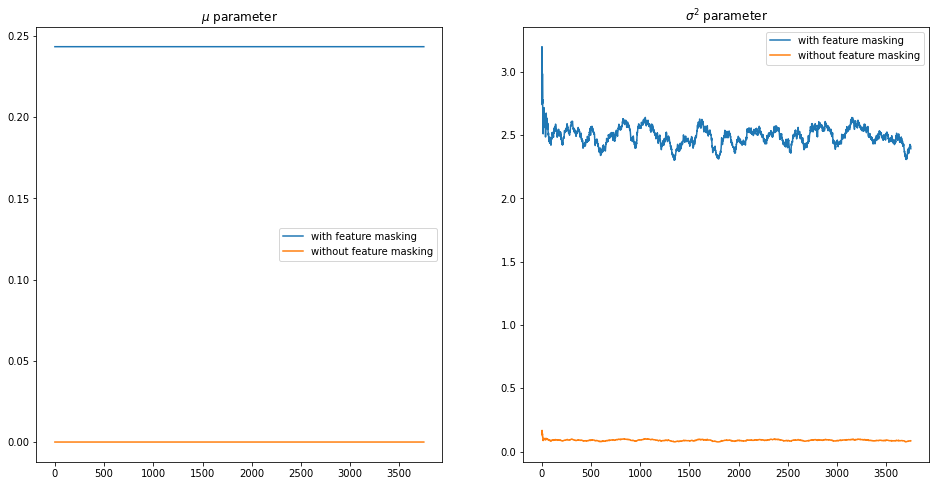

In [109]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))

axs[0].set_title("$\mu$ parameter")
axs[0].plot(mu_mse1, label="with feature masking")
axs[0].plot(mu_mse2, label="without feature masking")
axs[0].legend()

axs[1].set_title("$\sigma^2$ parameter")
axs[1].plot(sig_mse1, label="with feature masking")
axs[1].plot(sig_mse2, label="without feature masking")
axs[1].legend()

plt.show()
plt.close()